### Import libraries and MNIST set

In [1]:
import sys
import datetime
import numpy as np
import tensorflow as tf
from mlxtend.preprocessing import one_hot
from scipy import ndimage

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
N_train_data = x_train.shape[0]
N_test_data = x_test.shape[0]
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = x_train.reshape(N_train_data, -1).T
x_test = x_test.reshape(N_test_data, -1).T
y_train = y_train.reshape((N_train_data, 1)).T
y_test = y_test.reshape((N_test_data, 1)).T

print ("training set shape:", x_train.shape, y_train.shape)
print ("test set shape:", x_test.shape, y_test.shape)

training set shape: (784, 60000) (1, 60000)
test set shape: (784, 10000) (1, 10000)


[1]


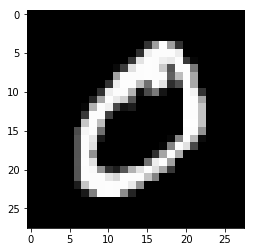

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = (x//2) - (cropx//2)
    starty = (y//2) - (cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

img = x_train[:,1].reshape((28,28))
print(y_train[:,3])
plt.imshow(img, cmap='gray')

### Define or load a multi-layer perceptron (MLP) neural network architecture

In [3]:
#layer_sizes = [784,20,10]
#layer_sizes = [784,40,10]
layer_sizes = [784,80,10]
#layer_sizes = [784,200,10]
#layer_sizes = [784,160,40,10]
#layer_sizes = [784,200,60,20,10] # L2_regularization_rate = 0.01

w = {i: np.random.rand(layer_sizes[i], layer_sizes[i-1]) * 2 -1 for i in range(1, len(layer_sizes))} # [0, 1) * 2 -1
b = {i: np.random.rand(layer_sizes[i]).reshape((layer_sizes[i], 1)) * 2 -1 for i in range(1, len(layer_sizes))} # [0, 1) * 2 -1

#layer_sizes, w, b = np.load("MLP 2019-02-24 10:21.npy") # layer_sizes = [784, 20, 10] 	test set accuracy = 0.9393
#layer_sizes, w, b = np.load("MLP 2019-02-24 10:31.npy") # layer_sizes = [784, 40, 10] 	test set accuracy = 0.9477
#layer_sizes, w, b = np.load("MLP 2019-03-07 21:52.npy") # layer_sizes = [784, 80, 10] 	test set accuracy = 0.9618
#layer_sizes, w, b = np.load("MLP 2019-02-23 13:47.npy") # layer_sizes = [784, 200, 10] 	test set accuracy = 0.9491
#layer_sizes, w, b = np.load("MLP 2019-02-23 12:44.npy") # layer_sizes = [784, 160, 40, 10] 	test set accuracy = 0.9472
#layer_sizes, w, b = np.load("MLP 2019-02-24 09:18.npy") # layer_sizes = [784, 200, 60, 20, 10] 	test set accuracy = 0.9559

N_layers = len(layer_sizes)
assert(N_layers > 2)
N_inputs = layer_sizes[0]
N_outputs = layer_sizes[-1]
input_layer = 0
output_layer = N_layers - 1

### Predict the test set

Linear equation: $$z^l = w^l a^{l-1} + b^l, \forall l \neq 0$$
ReLU activation function: $$a^l_i = \max(z^l_i, 0), \forall i, 0<l<output\_layer$$
Softmax function: $$p_i = \frac{e^{z^L_i}}{\Sigma_j e^{z^L_j}}, \forall i$$

In [4]:
z = dict()
a = dict()
def forward(x):
    '''#print ("== Forward ==")'''
    
    for l in range(1, N_layers):
        assert(not np.isnan(np.sum(w[l])))
        assert(not np.isnan(np.sum(b[l])))
    
    a[0] = x # input layer
    for l in range(1, output_layer): # hidden layers
        z[l] = np.matmul(w[l], a[l-1]) + b[l]
        assert(np.isfinite(np.sum(z[l])))
        a[l] = np.maximum(z[l], 0) # ReLU
        assert(np.isfinite(np.sum(a[l])))
    z[output_layer] = np.matmul(w[output_layer], a[output_layer-1]) + b[output_layer] # output layer
    assert(np.isfinite(np.sum(z[output_layer])))
    
    z[output_layer] = np.minimum(z[output_layer], 709) # force saturate
    exps = np.exp(z[output_layer])
    p = exps / np.sum(exps, axis=0) # softmax
    assert(np.isfinite(np.sum(p)))
    return p

In [5]:
p = forward(x_test)
y_ = np.argmax(p, axis=0).reshape((1, N_test_data))
accuracy = np.sum(y_ == y_test) / N_test_data
print ("layer_sizes =", layer_sizes, "\ttest set accuracy =", accuracy)

layer_sizes = [784, 80, 10] 	test set accuracy = 0.1257


In [6]:
#npy_filename = "MLP "+datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
#np.save(npy_filename, [layer_sizes, w, b])
#print ('save to', "'"+npy_filename+".npy'")

### Train the training set

In [7]:
# split a validation set from training set
x_valid = x_train[:, 0:10000]
y_valid = y_train[:, 0:10000]
x_train = x_train[:, 10000:60000]
y_train = y_train[:, 10000:60000]

N_training_data = y_train.shape[1]
N_validation_data = y_valid.shape[1]

y_train = one_hot(y_train[0]).T

print ("validation set shape:", x_valid.shape, y_valid.shape)
print ("training set shape:", x_train.shape, y_train.shape)

validation set shape: (784, 10000) (1, 10000)
training set shape: (784, 50000) (10, 50000)


Corss entropy loss function: $$J = -\sum_i (y_i \ln p_i + (1-y_i) \ln (1-p_i))$$
Derivative of cross entropy loss function: $$\frac{\partial J}{\partial p} = (\frac{1}{1-y-p})^\text{T} = dJdp$$
Derivative of softmax: $$\frac{\partial p}{\partial z^L} = \text{diag}(p)-pp^\text{T} = dpdz$$
Derivative of ReLU activation function: $$\text{diag}^{-1}(\frac{\partial a^l}{\partial z^l}) = z^l > 0 ? 1:0 = diag\_inv\_dadz[l]$$
Recursive formula by chain rule: 
$$\frac{\partial J}{\partial z^L} = \frac{\partial J}{\partial p} \frac{\partial p}{\partial z^L} \\
\Rightarrow dJdz[last\_layer] = dJdp \times dpdz$$
$$\frac{\partial J}{\partial z^l} = (\frac{\partial J}{\partial z^{l+1}} w^{l+1}) \otimes {\text{diag}^{-1}(\frac{\partial a^l}{\partial z^l})}^\text{T} \\
\Rightarrow dJdz[l] = (dJdz[l+1] \times w[l+1]) \otimes diag\_inv\_dadz[l]^\text{T}$$
Finally... 
$$\frac{\partial J}{\partial w^l} = a^{l-1} \frac{\partial J}{\partial z^l} = dJdw[l]$$
$$\frac{\partial J}{\partial b^l} = \frac{\partial J}{\partial z^l} = dJdb[l]$$

In [8]:
def backward(p, y):
    '''#print ("== Backward ==")'''
    
    assert(np.isfinite(np.sum(p)))
    assert(np.isfinite(np.sum(y)))
    for l in range(1, output_layer):
        assert(np.isfinite(np.sum(z[l])))
        assert(np.isfinite(np.sum(a[l])))
    assert(np.isfinite(np.sum(z[output_layer])))
    assert(p.shape[0] == N_outputs and p.shape[1] == batch_size)
    assert(y.shape[0] == N_outputs and y.shape[1] == batch_size)
    assert((1-y-p).all() != 0) # p should not be too close to neither 1 or 0
    
    p = np.maximum(p, 1.0e-307) # force saturate
    p = np.minimum(p, 1-1.0e-16) # force saturate
    dJdp = (1.0 / (1-y-p)).T # derivative of cross entropy
    assert(np.isfinite(np.sum(dJdp)))
    dpdz = np.zeros((batch_size, N_outputs, N_outputs))
    for i in range(batch_size):
        dpdz[i] = np.diag(p[:,i]) - np.outer(p[:,i], p[:,i]) # derivative of softmax
    assert(np.isfinite(np.sum(dpdz)))
    diag_inv_dadz = {i: np.where(e>0, 1, 0).T for i, e in z.items()} # derivative of ReLU
    
    dJdz = dict()
    dJdz[output_layer] = np.zeros((batch_size, N_outputs))
    for i in range(batch_size):
        dJdz[output_layer][i] = np.matmul(dJdp[i], dpdz[i])
    assert(np.isfinite(np.sum(dJdz[output_layer])))
    dJdw = dict()
    dJdw[output_layer] = np.matmul(a[output_layer-1], dJdz[output_layer]) / batch_size
    assert(np.isfinite(np.sum(dJdw[output_layer])))
    dJdb = dict()
    dJdb[output_layer] = np.average(dJdz[output_layer], axis=0).reshape((1, layer_sizes[output_layer]))
    assert(np.isfinite(np.sum(dJdb[output_layer])))
    
    for l in range(output_layer-1, 0, -1):
        dJdz[l] = np.matmul(dJdz[l+1], w[l+1]) * diag_inv_dadz[l]
        assert(np.isfinite(np.sum(dJdz[l])))
        dJdw[l] = np.matmul(a[l-1], dJdz[l]) / batch_size
        assert(np.isfinite(np.sum(dJdw[l])))
        dJdb[l] = np.average(dJdz[l], axis=0).reshape((1, layer_sizes[l]))
        assert(np.isfinite(np.sum(dJdb[l])))
    
    return dJdw, dJdb

In [9]:
epsilon = 0.1 # learning rate
L2_regularization_rate = 0.0 # e.g. 0.0, 0.001
batch_size = 500
assert(N_training_data % batch_size == 0)

batches_per_epoch = int(N_training_data / batch_size)
print ("layer_sizes =", layer_sizes, "\t#training data =", N_training_data, "\t#batches_per_epoch =", batches_per_epoch)
assert(batches_per_epoch <= 100 or batches_per_epoch % 100 == 0)

def data_augmentation(x, y):
    for i in range(batch_size):
        degree = np.random.rand() * 60 - 30 # [0, 1) * 60 - 30
        #degree = 30
        img = x[:, i].reshape((28,28))
        img = ndimage.rotate(img, degree)
        img = crop_center(img, 28, 28)
        x[:, i] = img.reshape(784)
    return x, y

start_time = datetime.datetime.now()
for epoch in range(1000):
    J = 0
    training_accuracy = 0
    for i in range(batches_per_epoch):
        if batches_per_epoch <= 100 or i % int(batches_per_epoch/100) == 0:
            sys.stdout.write('.')
        
        x_batch = x_train[:, i*batch_size:(i+1)*batch_size].copy()
        y_batch = y_train[:, i*batch_size:(i+1)*batch_size].copy()
        #x_batch, y_batch = data_augmentation(x_batch, y_batch)
        
        p = forward(x_batch)
        
        p = np.maximum(p, 1.0e-323) # force saturate
        p = np.minimum(p, 1-1.0e-16) # force saturate
        J += -1.0 * (np.sum(y_batch*np.log(p) + (1-y_batch)*np.log(1-p))) # cross entropy
        for l in range(1, N_layers):
            J += L2_regularization_rate * (np.einsum('ij,ij', w[l], w[l]) + np.einsum('ij,ij', b[l], b[l]))
        y_ = np.argmax(p, axis=0) # an implicity transpose is applied
        training_accuracy += np.minimum(1.0, np.sum(y_ == y_batch) / batch_size)
        
        dJdw, dJdb = backward(p, y_batch)
        for l in range(1, N_layers):
            dJdw[l] += L2_regularization_rate * 2.0 * (w[l].T)
            dJdb[l] += L2_regularization_rate * 2.0 * (b[l].T)
        
        for l in range(1, N_layers):
            w[l] = w[l] - epsilon * (dJdw[l].T)
            b[l] = b[l] - epsilon * (dJdb[l].T)
    
    training_accuracy = training_accuracy / batches_per_epoch
    p = forward(x_valid)
    y_ = np.argmax(p, axis=0) # an implicity transpose is applied
    validation_accuracy = np.sum(y_ == y_valid) / N_validation_data

    print ("\r", epoch, "\ttraining set loss&accuracy:", '%.0f'%J, '%.4f'%training_accuracy, "\tvalidation set accuracy:", '%.4f'%validation_accuracy, "")
print('--- Duration', datetime.datetime.now() - start_time, ' ---')

layer_sizes = [784, 80, 10] 	#training data = 50000 	#batches_per_epoch = 100
 0 	training set loss&accuracy: 239178 0.9444 	validation set accuracy: 0.8095 .....................
 1 	training set loss&accuracy: 73716 0.9598 	validation set accuracy: 0.8442 ......................
 2 	training set loss&accuracy: 53943 0.9579 	validation set accuracy: 0.8609 ......................
 3 	training set loss&accuracy: 44966 0.9571 	validation set accuracy: 0.8701 ......................
 4 	training set loss&accuracy: 39776 0.9582 	validation set accuracy: 0.8782 ......................
 5 	training set loss&accuracy: 36300 0.9576 	validation set accuracy: 0.8832 ......................
 6 	training set loss&accuracy: 33766 0.9592 	validation set accuracy: 0.8871 ......................
 7 	training set loss&accuracy: 31807 0.9602 	validation set accuracy: 0.8900 ......................
 8 	training set loss&accuracy: 30238 0.9606 	validation set accuracy: 0.8936 ......................
 9 	training 

 80 	training set loss&accuracy: 11276 0.9616 	validation set accuracy: 0.9467 .....................
 81 	training set loss&accuracy: 11195 0.9616 	validation set accuracy: 0.9468 .....................
 82 	training set loss&accuracy: 11116 0.9618 	validation set accuracy: 0.9472 .....................
 83 	training set loss&accuracy: 11039 0.9617 	validation set accuracy: 0.9473 .....................
 84 	training set loss&accuracy: 10961 0.9617 	validation set accuracy: 0.9477 .....................
 85 	training set loss&accuracy: 10885 0.9617 	validation set accuracy: 0.9475 .....................
 86 	training set loss&accuracy: 10810 0.9619 	validation set accuracy: 0.9476 .....................
 87 	training set loss&accuracy: 10736 0.9620 	validation set accuracy: 0.9479 .....................
 88 	training set loss&accuracy: 10664 0.9618 	validation set accuracy: 0.9483 .....................
 89 	training set loss&accuracy: 10592 0.9615 	validation set accuracy: 0.9487 ............

 161 	training set loss&accuracy: 6950 0.9605 	validation set accuracy: 0.9555 .....................
 162 	training set loss&accuracy: 6913 0.9605 	validation set accuracy: 0.9555 .....................
 163 	training set loss&accuracy: 6877 0.9607 	validation set accuracy: 0.9556 .....................
 164 	training set loss&accuracy: 6840 0.9607 	validation set accuracy: 0.9557 .....................
 165 	training set loss&accuracy: 6804 0.9607 	validation set accuracy: 0.9557 .....................
 166 	training set loss&accuracy: 6768 0.9607 	validation set accuracy: 0.9555 .....................
 167 	training set loss&accuracy: 6733 0.9607 	validation set accuracy: 0.9556 .....................
 168 	training set loss&accuracy: 6698 0.9606 	validation set accuracy: 0.9556 .....................
 169 	training set loss&accuracy: 6663 0.9609 	validation set accuracy: 0.9557 .....................
 170 	training set loss&accuracy: 6628 0.9607 	validation set accuracy: 0.9557 ............

 242 	training set loss&accuracy: 4563 0.9599 	validation set accuracy: 0.9561 .....................
 243 	training set loss&accuracy: 4539 0.9599 	validation set accuracy: 0.9560 .....................
 244 	training set loss&accuracy: 4516 0.9599 	validation set accuracy: 0.9561 .....................
 245 	training set loss&accuracy: 4492 0.9599 	validation set accuracy: 0.9560 .....................
 246 	training set loss&accuracy: 4469 0.9599 	validation set accuracy: 0.9559 .....................
 247 	training set loss&accuracy: 4445 0.9599 	validation set accuracy: 0.9559 .....................
 248 	training set loss&accuracy: 4422 0.9599 	validation set accuracy: 0.9559 .....................
 249 	training set loss&accuracy: 4399 0.9598 	validation set accuracy: 0.9560 .....................
 250 	training set loss&accuracy: 4376 0.9600 	validation set accuracy: 0.9560 .....................
 251 	training set loss&accuracy: 4354 0.9600 	validation set accuracy: 0.9561 ............

 322 	training set loss&accuracy: 2992 0.9588 	validation set accuracy: 0.9576 .....................
 323 	training set loss&accuracy: 2976 0.9588 	validation set accuracy: 0.9577 .....................
 324 	training set loss&accuracy: 2960 0.9588 	validation set accuracy: 0.9577 .....................
 325 	training set loss&accuracy: 2944 0.9588 	validation set accuracy: 0.9577 .....................
 326 	training set loss&accuracy: 2928 0.9588 	validation set accuracy: 0.9577 .....................
 327 	training set loss&accuracy: 2913 0.9590 	validation set accuracy: 0.9576 .....................
 328 	training set loss&accuracy: 2897 0.9588 	validation set accuracy: 0.9577 .....................
 329 	training set loss&accuracy: 2882 0.9588 	validation set accuracy: 0.9577 .....................
 330 	training set loss&accuracy: 2866 0.9590 	validation set accuracy: 0.9576 .....................
 331 	training set loss&accuracy: 2851 0.9588 	validation set accuracy: 0.9577 ............

 403 	training set loss&accuracy: 1944 0.9590 	validation set accuracy: 0.9579 .....................
 404 	training set loss&accuracy: 1934 0.9590 	validation set accuracy: 0.9579 .....................
 405 	training set loss&accuracy: 1924 0.9590 	validation set accuracy: 0.9579 .....................
 406 	training set loss&accuracy: 1914 0.9590 	validation set accuracy: 0.9577 .....................
 407 	training set loss&accuracy: 1904 0.9590 	validation set accuracy: 0.9578 .....................
 408 	training set loss&accuracy: 1894 0.9588 	validation set accuracy: 0.9577 .....................
 409 	training set loss&accuracy: 1884 0.9588 	validation set accuracy: 0.9579 .....................
 410 	training set loss&accuracy: 1875 0.9588 	validation set accuracy: 0.9579 .....................
 411 	training set loss&accuracy: 1865 0.9588 	validation set accuracy: 0.9578 .....................
 412 	training set loss&accuracy: 1855 0.9588 	validation set accuracy: 0.9579 ............

 484 	training set loss&accuracy: 1279 0.9588 	validation set accuracy: 0.9580 .....................
 485 	training set loss&accuracy: 1272 0.9588 	validation set accuracy: 0.9580 .....................
 486 	training set loss&accuracy: 1265 0.9588 	validation set accuracy: 0.9581 .....................
 487 	training set loss&accuracy: 1259 0.9588 	validation set accuracy: 0.9581 .....................
 488 	training set loss&accuracy: 1253 0.9588 	validation set accuracy: 0.9581 .....................
 489 	training set loss&accuracy: 1247 0.9588 	validation set accuracy: 0.9581 .....................
 490 	training set loss&accuracy: 1240 0.9588 	validation set accuracy: 0.9581 .....................
 491 	training set loss&accuracy: 1234 0.9588 	validation set accuracy: 0.9581 .....................
 492 	training set loss&accuracy: 1228 0.9588 	validation set accuracy: 0.9580 .....................
 493 	training set loss&accuracy: 1222 0.9588 	validation set accuracy: 0.9579 ............

 565 	training set loss&accuracy: 848 0.9588 	validation set accuracy: 0.9584 ......................
 566 	training set loss&accuracy: 844 0.9588 	validation set accuracy: 0.9586 ......................
 567 	training set loss&accuracy: 839 0.9588 	validation set accuracy: 0.9586 ......................
 568 	training set loss&accuracy: 835 0.9588 	validation set accuracy: 0.9587 ......................
 569 	training set loss&accuracy: 831 0.9588 	validation set accuracy: 0.9587 ......................
 570 	training set loss&accuracy: 827 0.9588 	validation set accuracy: 0.9589 ......................
 571 	training set loss&accuracy: 822 0.9588 	validation set accuracy: 0.9588 ......................
 572 	training set loss&accuracy: 818 0.9588 	validation set accuracy: 0.9588 ......................
 573 	training set loss&accuracy: 814 0.9588 	validation set accuracy: 0.9588 ......................
 574 	training set loss&accuracy: 810 0.9588 	validation set accuracy: 0.9588 .............

 646 	training set loss&accuracy: 565 0.9588 	validation set accuracy: 0.9596 ......................
 647 	training set loss&accuracy: 562 0.9588 	validation set accuracy: 0.9596 ......................
 648 	training set loss&accuracy: 559 0.9588 	validation set accuracy: 0.9596 ......................
 649 	training set loss&accuracy: 557 0.9588 	validation set accuracy: 0.9595 ......................
 650 	training set loss&accuracy: 554 0.9588 	validation set accuracy: 0.9597 ......................
 651 	training set loss&accuracy: 551 0.9588 	validation set accuracy: 0.9597 ......................
 652 	training set loss&accuracy: 548 0.9588 	validation set accuracy: 0.9597 ......................
 653 	training set loss&accuracy: 546 0.9587 	validation set accuracy: 0.9595 ......................
 654 	training set loss&accuracy: 543 0.9587 	validation set accuracy: 0.9597 ......................
 655 	training set loss&accuracy: 540 0.9587 	validation set accuracy: 0.9599 .............

 727 	training set loss&accuracy: 383 0.9586 	validation set accuracy: 0.9604 ......................
 728 	training set loss&accuracy: 381 0.9586 	validation set accuracy: 0.9604 ......................
 729 	training set loss&accuracy: 379 0.9586 	validation set accuracy: 0.9604 ......................
 730 	training set loss&accuracy: 377 0.9586 	validation set accuracy: 0.9604 ......................
 731 	training set loss&accuracy: 376 0.9586 	validation set accuracy: 0.9604 ......................
 732 	training set loss&accuracy: 374 0.9586 	validation set accuracy: 0.9604 ......................
 733 	training set loss&accuracy: 372 0.9586 	validation set accuracy: 0.9603 ......................
 734 	training set loss&accuracy: 370 0.9586 	validation set accuracy: 0.9603 ......................
 735 	training set loss&accuracy: 369 0.9586 	validation set accuracy: 0.9603 ......................
 736 	training set loss&accuracy: 367 0.9586 	validation set accuracy: 0.9603 .............

 808 	training set loss&accuracy: 269 0.9586 	validation set accuracy: 0.9611 ......................
 809 	training set loss&accuracy: 268 0.9586 	validation set accuracy: 0.9611 ......................
 810 	training set loss&accuracy: 267 0.9586 	validation set accuracy: 0.9611 ......................
 811 	training set loss&accuracy: 266 0.9586 	validation set accuracy: 0.9611 ......................
 812 	training set loss&accuracy: 265 0.9586 	validation set accuracy: 0.9612 ......................
 813 	training set loss&accuracy: 264 0.9586 	validation set accuracy: 0.9612 ......................
 814 	training set loss&accuracy: 263 0.9586 	validation set accuracy: 0.9612 ......................
 815 	training set loss&accuracy: 262 0.9586 	validation set accuracy: 0.9612 ......................
 816 	training set loss&accuracy: 261 0.9586 	validation set accuracy: 0.9613 ......................
 817 	training set loss&accuracy: 260 0.9586 	validation set accuracy: 0.9611 .............

 889 	training set loss&accuracy: 203 0.9586 	validation set accuracy: 0.9611 ......................
 890 	training set loss&accuracy: 202 0.9586 	validation set accuracy: 0.9611 ......................
 891 	training set loss&accuracy: 201 0.9586 	validation set accuracy: 0.9611 ......................
 892 	training set loss&accuracy: 201 0.9586 	validation set accuracy: 0.9611 ......................
 893 	training set loss&accuracy: 200 0.9586 	validation set accuracy: 0.9611 ......................
 894 	training set loss&accuracy: 199 0.9586 	validation set accuracy: 0.9610 ......................
 895 	training set loss&accuracy: 199 0.9586 	validation set accuracy: 0.9611 ......................
 896 	training set loss&accuracy: 198 0.9586 	validation set accuracy: 0.9611 ......................
 897 	training set loss&accuracy: 197 0.9586 	validation set accuracy: 0.9611 ......................
 898 	training set loss&accuracy: 197 0.9586 	validation set accuracy: 0.9610 .............

 970 	training set loss&accuracy: 158 0.9586 	validation set accuracy: 0.9609 ......................
 971 	training set loss&accuracy: 157 0.9586 	validation set accuracy: 0.9609 ......................
 972 	training set loss&accuracy: 157 0.9586 	validation set accuracy: 0.9609 ......................
 973 	training set loss&accuracy: 157 0.9586 	validation set accuracy: 0.9609 ......................
 974 	training set loss&accuracy: 156 0.9586 	validation set accuracy: 0.9609 ......................
 975 	training set loss&accuracy: 156 0.9586 	validation set accuracy: 0.9609 ......................
 976 	training set loss&accuracy: 155 0.9586 	validation set accuracy: 0.9609 ......................
 977 	training set loss&accuracy: 155 0.9586 	validation set accuracy: 0.9609 ......................
 978 	training set loss&accuracy: 154 0.9586 	validation set accuracy: 0.9610 ......................
 979 	training set loss&accuracy: 154 0.9586 	validation set accuracy: 0.9610 .............